In [126]:
## Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os,sys
from glob import glob
import calendar
%matplotlib inline

In [127]:
plt.rcParams["figure.figsize"] = (20, 10)

In [128]:
RAW_PATH = './raw_data'
files = glob(RAW_PATH+'/*.csv')
files

['./raw_data\\calendar.csv',
 './raw_data\\listings.csv',
 './raw_data\\reviews.csv']

## Exploring each dataset

We'll start with Calendar, Reviews, an Listings respectively

### Calendar

In [129]:
calen_df = pd.read_csv(files[0], date_parser='date')
print(calen_df.info())
print("=="*40)
calen_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN


### Let's try to structure this:

Key objective: Find what do Bostonian care when they pick a place to stay on AirBnb


1. What kind of accommodation do they have in Boston?

2. Which are generally get occupied?

3. Which factors make them so hot for bostonians?



Calendar dataset contains listing_id of each listing with its availability and price for each day

Half of the price is null'

In [130]:
def price_cleaning(df:pd.DataFrame, col:str):
    """
    Clean columns related to prices
    INPUT:
    df: Dataframe that contains price-like values
    col: Columns name that contains price-like values
    """ 
    temp = df.copy()
    temp[col] = temp[col].str.replace(',', '')
    temp[col] = temp[col].str.replace('$', '')
    temp[col] = temp[col].astype(float) 
    temp[col] = temp[col].fillna(0)
    return temp[col]

In [131]:
# calen_df['pn'] = calen_df['price'].isna()
# calen_df.groupby(by=['available','pn'], as_index=False)['listing_id'].count().sort_values(by='listing_id',ascending=False)
calen_df['listing_id'] = calen_df['listing_id'].astype('string') 
calen_df['date'] = pd.to_datetime(calen_df['date']).dt.date
calen_df['date'] = calen_df['date'].astype('datetime64')
calen_df['price'] = price_cleaning(df=calen_df,col='price')
calen_df['have_price'] = np.where(calen_df['price']==0,0,1)
calen_df.head(2)

c:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


,listing_id,date,available,price,have_price
0,12147973,2017-09-05,f,0.0,0
1,12147973,2017-09-04,f,0.0,0


In [132]:
calen_df['day_of_week'] = pd.to_datetime(calen_df['date']).dt.day_name()
calen_df['wd_wn'] = np.where(
    (calen_df['day_of_week']=='Saturday') | (calen_df['day_of_week']=='Sunday'),
    'Weekend',
    'Weekday' 
)
calen_df.head()

,listing_id,date,available,price,have_price,day_of_week,wd_wn
0,12147973,2017-09-05,f,0.0,0,Tuesday,Weekday
1,12147973,2017-09-04,f,0.0,0,Monday,Weekday
2,12147973,2017-09-03,f,0.0,0,Sunday,Weekend
3,12147973,2017-09-02,f,0.0,0,Saturday,Weekend
4,12147973,2017-09-01,f,0.0,0,Friday,Weekday


In [133]:
## Base on values down below we can assume that if the listing is booked/full they won't have price
calen_df.groupby(by=['have_price','available'])['listing_id'].count().head(50)

have_price  available
0           f            665853
1           t            643037
Name: listing_id, dtype: int64

Let's the occupied rate throughout the year

In [134]:
calen_df.groupby(by=['listing_id', 'have_price'], as_index=False)['date'].count()

,listing_id,have_price,date
0,10004575,0,275
1,10004575,1,90
2,10009367,0,365
3,10021398,0,37
4,10021398,1,328
...,...,...,...
6383,9993826,0,186
6384,9993826,1,179
6385,9998187,0,275
6386,9998187,1,90


In [135]:
occupied_rate = calen_df.groupby(by=['listing_id', 'have_price'], as_index=False)['date'].count().pivot_table(index=['listing_id'], columns=['have_price'], values=['date'])
occupied_rate = occupied_rate.reset_index()
occupied_rate.columns = ['listing_id','price_yes','price_no']
occupied_rate= occupied_rate.fillna(0)
occupied_rate['occupied_pct'] = occupied_rate.price_no/(occupied_rate.price_no+occupied_rate.price_yes)
occupied_rate.head()

,listing_id,price_yes,price_no,occupied_pct
0,10004575,275.0,90.0,0.246575
1,10009367,365.0,0.0,0.000000
2,10021398,37.0,328.0,0.898630
3,10032327,290.0,75.0,0.205479
4,10033322,186.0,179.0,0.490411


In [136]:
occupied_rate.shape[0]

3585

In [137]:
occupied_rate[occupied_rate.occupied_pct==1]

,listing_id,price_yes,price_no,occupied_pct
14,10036192,0.0,365.0,1.0
21,10051649,0.0,365.0,1.0
61,10127270,0.0,365.0,1.0
141,10567830,0.0,365.0,1.0
170,10742655,0.0,365.0,1.0
...,...,...,...,...
3351,9180965,0.0,365.0,1.0
3497,973695,0.0,365.0,1.0
3529,9854083,0.0,365.0,1.0
3563,9926796,0.0,365.0,1.0


What are the occupied rates distribution in Boston

<AxesSubplot:xlabel='occupied_pct', ylabel='Count'>

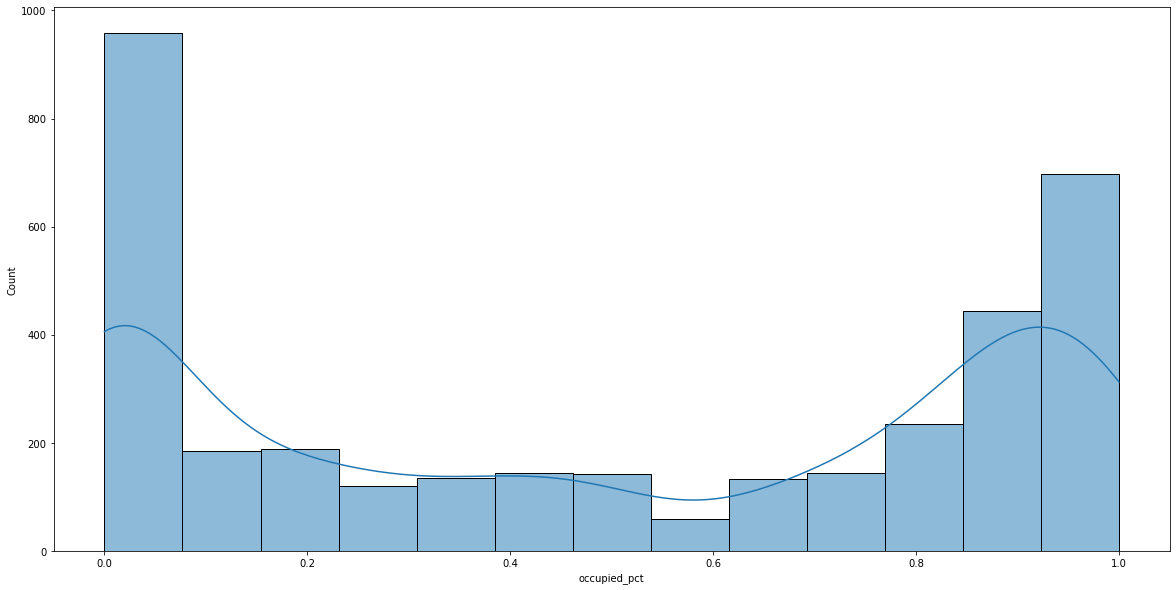

In [138]:
sns.histplot(occupied_rate.occupied_pct, kde=True)

In [139]:
daily_availability = calen_df.groupby(by=['date', 'available'], as_index=False)['listing_id'].count().pivot_table(index=['date'], columns=['available'],values=['listing_id']).reset_index()
daily_availability.columns = ['date','full','vacant']
daily_availability['occupied_rate'] = daily_availability.full/(daily_availability.full+daily_availability.vacant)
daily_availability['total_listing'] = (daily_availability.full+daily_availability.vacant)
daily_availability.head(3)

,date,full,vacant,occupied_rate,total_listing
0,2016-09-06,3016,570,0.841049,3586
1,2016-09-07,2654,932,0.740100,3586
2,2016-09-08,2587,999,0.721417,3586


<AxesSubplot:xlabel='date', ylabel='total_listing'>

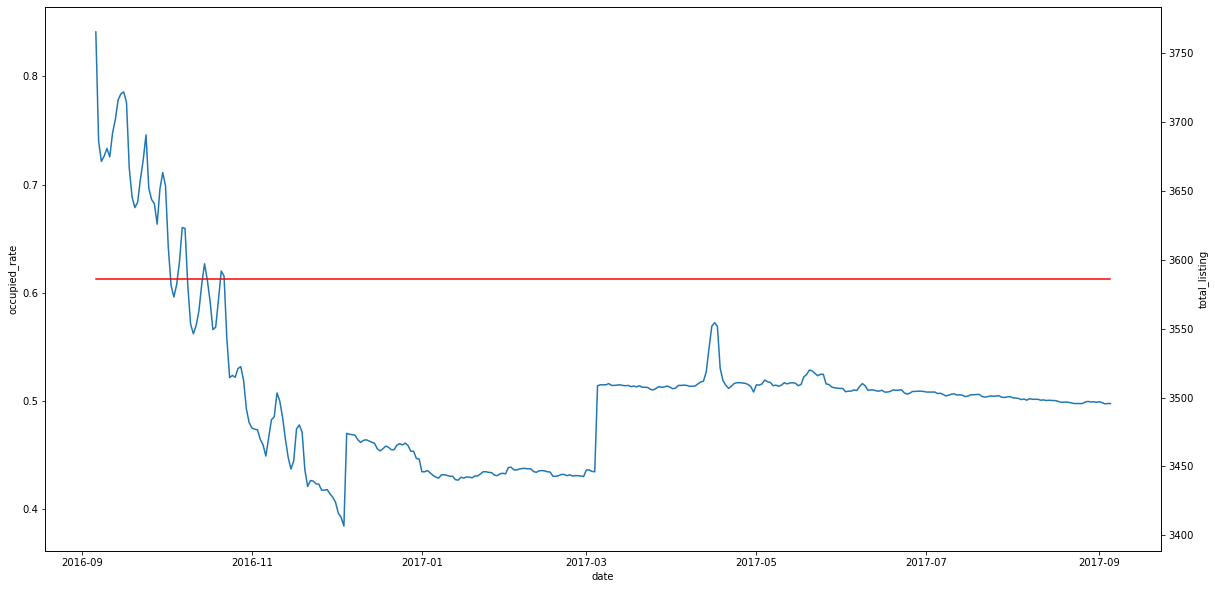

In [140]:
fig, ax = plt.subplots(1)
sns.lineplot(data=daily_availability, x='date',y='occupied_rate', ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=daily_availability, x='date', y='total_listing', ax=ax2, color='red')

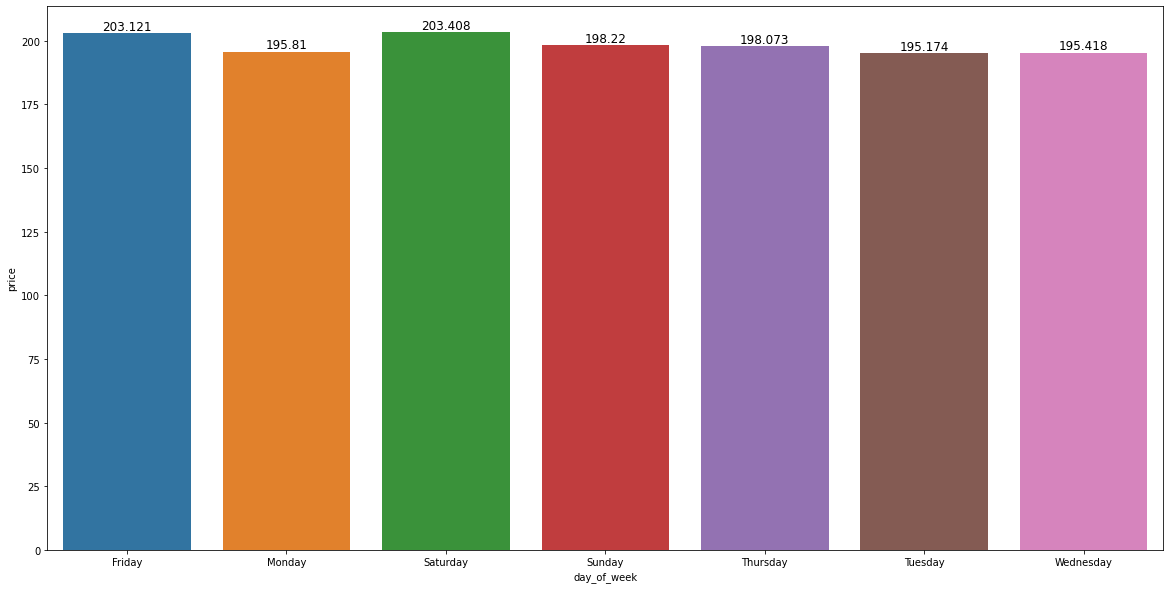

In [141]:
fig, ax = plt.subplots(1)
sns.barplot(
    data=calen_df.loc[calen_df['available']!='f'].groupby(by=['day_of_week'],
    as_index=False)['price'].mean(),
    x='day_of_week',
    y='price',
    ax=ax)
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

### Reviews

In [142]:
review_df = pd.read_csv(files[2])
review_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


### Listing

In [143]:
listing = pd.read_csv(files[1])
listing.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


In [144]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Below are sample data of listing dataset

In [145]:
listing.iloc[:2,:10].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ..."
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima..."


In [146]:
listing.iloc[:2,10:20].head()

,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id
0,NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940
1,"If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247


In [147]:
listing.iloc[:2,20:30].head()

,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url
0,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...
1,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...


In [148]:
listing.iloc[:2,30:40].head()

,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed
0,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale
1,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale


In [149]:
listing.iloc[:2,40:60].head()

,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet
0,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN
1,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.286241,-71.134374,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN


In [150]:
listing.iloc[:2,60:80].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating
0,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN
1,$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0


In [151]:
listing.iloc[:2,80:].head()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


In [152]:
listing[listing.id==10036192]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2334,10036192,https://www.airbnb.com/rooms/10036192,20160906204935,2016-09-07,New Luxury 2BR Apt at Fenway,This furnished apartment is complete with a fu...,B995/803,This furnished apartment is complete with a fu...,none,NaN,...,NaN,f,NaN,NaN,f,strict,f,f,136,NaN


In [153]:
listing_required = listing[['id', 'experiences_offered',
       'transit','host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost','host_verifications',
        'street','neighbourhood_cleansed', 'city',
        'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value','cancellation_policy']]
listing_required.head(2)

,id,experiences_offered,transit,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,street,neighbourhood_cleansed,...,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy
0,12147973,none,"The bus stop is 2 blocks away, and frequent. B...",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews']","Birch Street, Boston, MA 02131, United States",Roslindale,...,1125,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,moderate
1,3075044,none,Plenty of safe street parking. Bus stops a few...,within an hour,100%,100%,f,"['email', 'phone', 'facebook', 'linkedin', 'am...","Pinehurst Street, Boston, MA 02131, United States",Roslindale,...,15,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0,moderate


In [154]:
listing_required.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3585 non-null   int64  
 1   experiences_offered          3585 non-null   object 
 2   transit                      2295 non-null   object 
 3   host_response_time           3114 non-null   object 
 4   host_response_rate           3114 non-null   object 
 5   host_acceptance_rate         3114 non-null   object 
 6   host_is_superhost            3585 non-null   object 
 7   host_verifications           3585 non-null   object 
 8   street                       3585 non-null   object 
 9   neighbourhood_cleansed       3585 non-null   object 
 10  city                         3583 non-null   object 
 11  property_type                3582 non-null   object 
 12  room_type                    3585 non-null   object 
 13  accommodates      

In [155]:
listing_required.isna().mean()

id                             0.000000
experiences_offered            0.000000
transit                        0.359833
host_response_time             0.131381
host_response_rate             0.131381
host_acceptance_rate           0.131381
host_is_superhost              0.000000
host_verifications             0.000000
street                         0.000000
neighbourhood_cleansed         0.000000
city                           0.000558
property_type                  0.000837
room_type                      0.000000
accommodates                   0.000000
bathrooms                      0.003905
bedrooms                       0.002789
beds                           0.002510
bed_type                       0.000000
amenities                      0.000000
square_feet                    0.984379
price                          0.000000
weekly_price                   0.751185
monthly_price                  0.752301
security_deposit               0.625662
cleaning_fee                   0.308787


### Cleaning some data

In [156]:
listing_required = listing_required.drop(columns=['neighbourhood_cleansed','square_feet'])
listing_required['longterm_promo'] = np.where(((listing_required.weekly_price.isna())|(listing_required.monthly_price.isna())),
        1,
        0)
listing_required = listing_required.drop(columns=['monthly_price','weekly_price','experiences_offered','city'])
listing_required['id'] = listing_required['id'].astype('string')

In [157]:
tf_map = {'f':0,'t':1}
response_rate_map = dict(zip(['within an hour', 'within a few hours', 'within a day',
       'a few days or more',''],
       [0, 1, 2, 3,np.nan])
       )
cancel_strictness = dict(zip(['flexible','moderate', 'strict', 'super_strict_30'],
       [0, 1, 2, 3])
       )
listing_required['host_is_superhost']= listing_required['host_is_superhost'].apply(lambda x: tf_map[x]).astype('float64')
listing_required['host_response_time'] = listing_required['host_response_time'].fillna('').apply(lambda x: response_rate_map[x]).astype('float64') 
listing_required['host_verifications'] = listing_required['host_verifications'].apply(lambda x: x.count(','))
listing_required['cancellation_policy'] = listing_required['cancellation_policy'].apply(lambda x: cancel_strictness[x]).astype('float64')
# listing_required['review_score_sum'] = listing_required.review_scores_accuracy * listing_required.review_scores_value
listing_required = listing_required.drop(columns=['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location'
 ]
)
for col in ['host_response_rate', 'host_acceptance_rate']:
    fix_rates =[]
    for val in listing_required[col]:
        try:
            fix_rates.append(val.replace('%',''))
        except:
            fix_rates.append(val)
    listing_required[col] = fix_rates
    listing_required[col] = listing_required[col].astype('float64')
listing_required['street'] =listing_required['street'].apply(lambda x: x.split(',')[0])
 

In [158]:
listing_required.street.value_counts()

Commonwealth Avenue     109
Beacon Street            91
Boylston Street          82
Washington Street        79
Tremont Street           66
                       ... 
Jeffries Street           1
Everett Street            1
Sumner St                 1
Lubec St                  1
George St Somerville      1
Name: street, Length: 1046, dtype: int64

In [159]:
listing_required.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3585 non-null   string 
 1   transit               2295 non-null   object 
 2   host_response_time    3114 non-null   float64
 3   host_response_rate    3114 non-null   float64
 4   host_acceptance_rate  3114 non-null   float64
 5   host_is_superhost     3585 non-null   float64
 6   host_verifications    3585 non-null   int64  
 7   street                3585 non-null   object 
 8   property_type         3582 non-null   object 
 9   room_type             3585 non-null   object 
 10  accommodates          3585 non-null   int64  
 11  bathrooms             3571 non-null   float64
 12  bedrooms              3575 non-null   float64
 13  beds                  3576 non-null   float64
 14  bed_type              3585 non-null   object 
 15  amenities            

In [160]:
for price_col in ['price', 'security_deposit','cleaning_fee', 'extra_people']:
    listing_required[price_col] = price_cleaning(listing_required,  price_col)

c:\Users\racha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


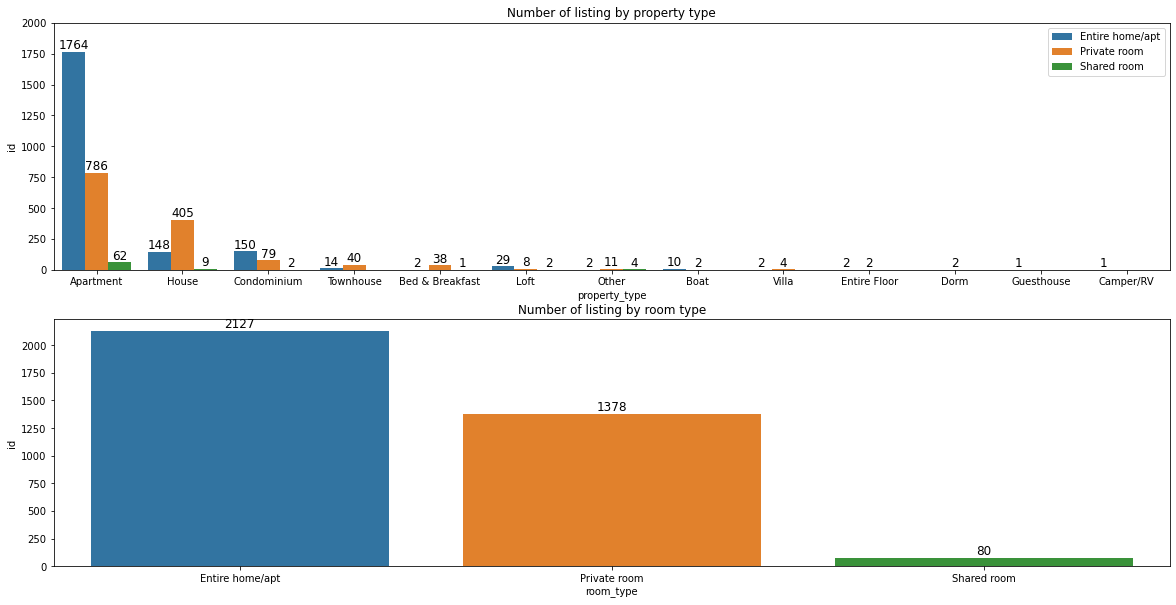

In [161]:
fig, ax = plt.subplots(2)
sns.barplot(data=listing_required.groupby(by=['property_type', 'room_type'],as_index=False)['id'].count().sort_values(by='id',ascending=False),
            x='property_type', 
            y='id', 
            hue='room_type',
            ax=ax[0])
sns.barplot(data=listing_required.groupby(by=['room_type'],as_index=False)['id'].count(), x='room_type', y='id', ax=ax[1])
ax[0].set_title('Number of listing by property type')
ax[0].set_ylim(0,2000)
ax[0].legend(loc='upper right')
ax[1].set_title('Number of listing by room type')
for axs in ax:
    for container in axs.containers:
        axs.bar_label(container, fontsize=12)
    

In [162]:
(listing_required.property_type.value_counts()/listing_required.shape[0]).cumsum()

Apartment          0.728591
House              0.885356
Condominium        0.949791
Townhouse          0.964854
Bed & Breakfast    0.976290
Loft               0.987169
Other              0.991911
Boat               0.995258
Villa              0.996932
Entire Floor       0.998047
Dorm               0.998605
Guesthouse         0.998884
Camper/RV          0.999163
Name: property_type, dtype: float64

In [163]:
listing_required.iloc[:2,9:]

,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_value,cancellation_policy,longterm_promo
0,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,0.0,35.0,1,0.0,2,1125,0,NaN,1.0,1
1,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",65.0,95.0,10.0,0,0.0,2,15,36,9.0,1.0,1


In [164]:
listing_required.head(2)

,id,transit,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,street,property_type,room_type,...,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_value,cancellation_policy,longterm_promo
0,12147973,"The bus stop is 2 blocks away, and frequent. B...",NaN,NaN,NaN,0.0,3,Birch Street,House,Entire home/apt,...,0.0,35.0,1,0.0,2,1125,0,NaN,1.0,1
1,3075044,Plenty of safe street parking. Bus stops a few...,0.0,100.0,100.0,0.0,6,Pinehurst Street,Apartment,Private room,...,95.0,10.0,0,0.0,2,15,36,9.0,1.0,1


### Let's answer the questions

1. What kind of accommodation do they have in Boston?

2. Which are generally get occupied?

3. Which factors make them so hot for bostonians?

#### A.) Accomodation types in Boston

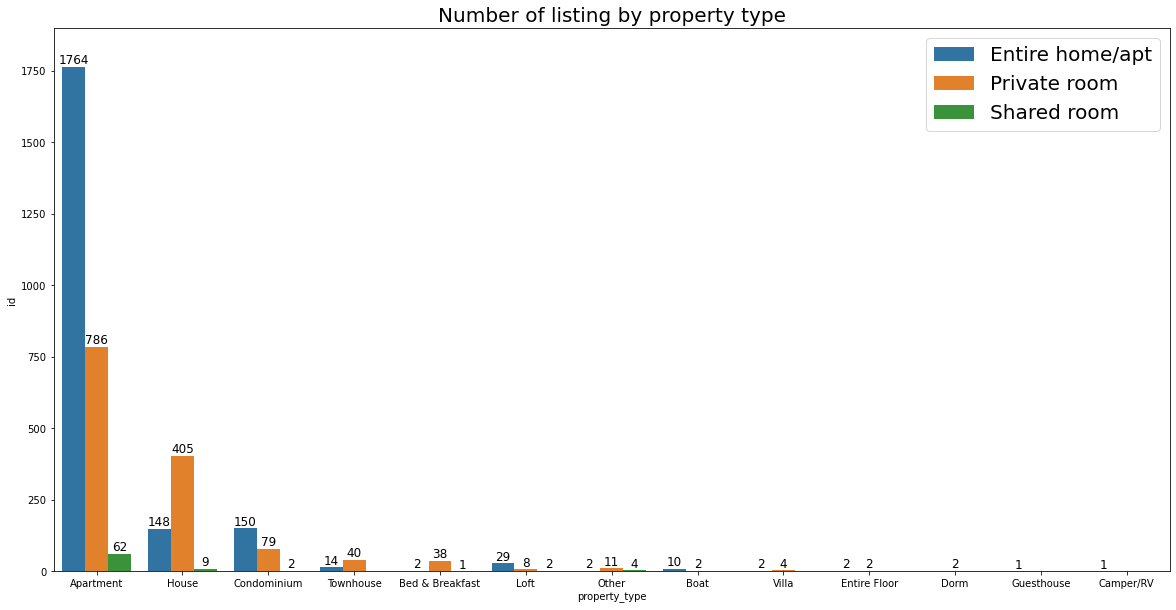

In [165]:
fig, ax = plt.subplots()
sns.barplot(data=listing_required.groupby(by=['property_type', 'room_type'],as_index=False)['id'].count().sort_values(by='id',ascending=False),
            x='property_type', 
            y='id', 
            hue='room_type',
            ax=ax)
# sns.barplot(data=listing_required.groupby(by=['room_type'],as_index=False)['id'].count(), x='room_type', y='id', ax=ax[1])
ax.set_title('Number of listing by property type', fontsize=20)
ax.set_ylim(0,1900)
# ax.set_xticks()
ax.legend(loc='upper right', fontsize=20)
# ax[1].set_title('Number of listing by room type')
# for axs in ax:
for container in ax.containers:
    ax.bar_label(container, fontsize=12)
    

In [166]:
listing_required = listing_required.loc[listing_required['property_type'].isin(['Apartment','House','Condominium'])] 

In [167]:
listing_required = listing_required.merge(occupied_rate[['listing_id','occupied_pct']],  
                                          how='left', 
                                          left_on='id', 
                                          right_on='listing_id').drop(columns=['listing_id'])
listing_required.head(1)

,id,transit,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,street,property_type,room_type,...,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_value,cancellation_policy,longterm_promo,occupied_pct
0,12147973,"The bus stop is 2 blocks away, and frequent. B...",NaN,NaN,NaN,0.0,3,Birch Street,House,Entire home/apt,...,35.0,1,0.0,2,1125,0,NaN,1.0,1,0.0


#### B.) Which are generally occupiied

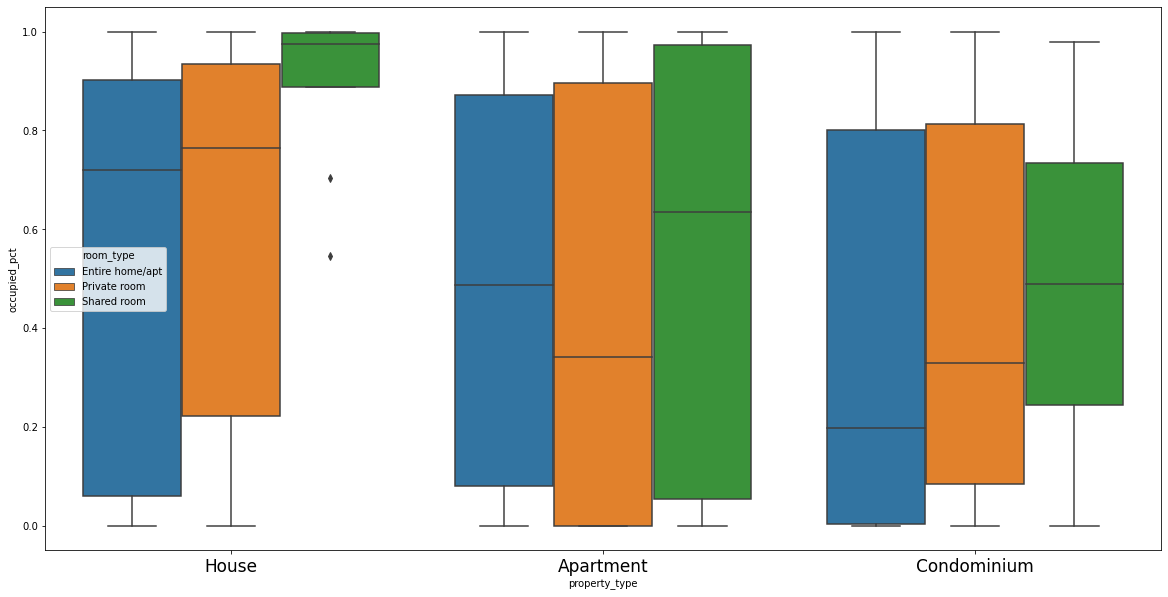

In [188]:
sns.boxplot(data=listing_required, x='property_type', y='occupied_pct', hue='room_type')
plt.tick_params(axis='x', labelsize=17)

### Which factors make them so hot for bostonians?

(0.0, 800.0)

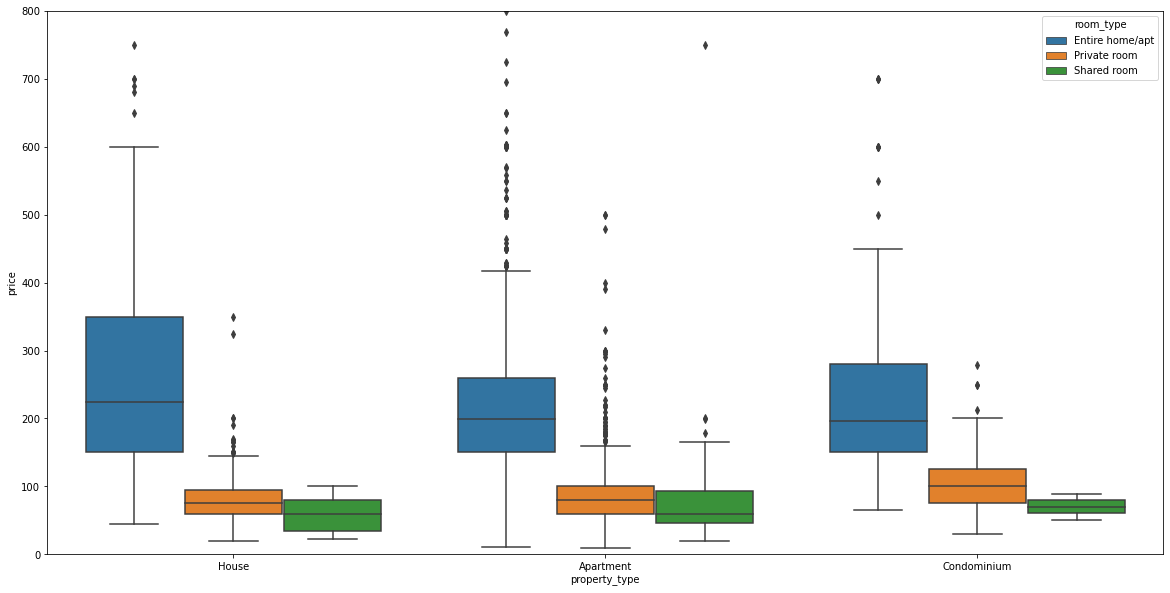

In [169]:
fig, ax = plt.subplots()
sns.boxplot(data=listing_required, x='property_type', y='price', hue='room_type', ax=ax)
ax.set_ylim(0,800)

<AxesSubplot:>

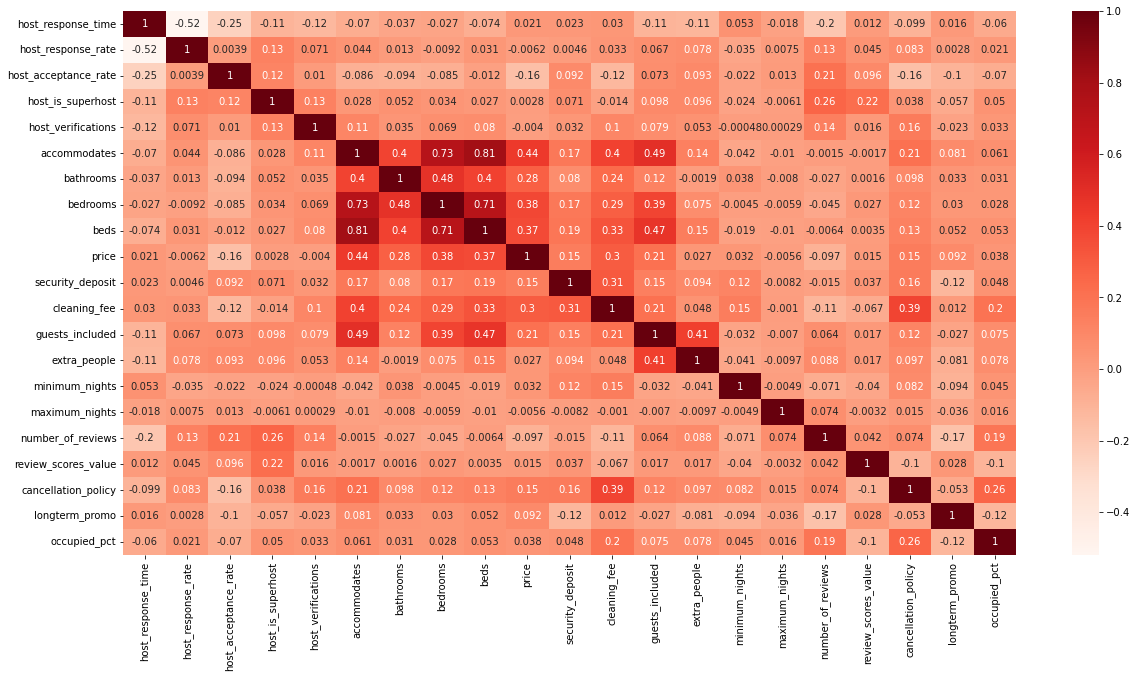

In [170]:
sns.heatmap(listing_required.corr(), cmap='Reds', annot=True)

In [171]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in tqdm(cat_cols):
        try:
            # for each cat add dummy var, drop original column
            print(f'{col} first value is: {df[col].unique()[0]}')
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [172]:
listing_required.bed_type.unique()

array(['Real Bed', 'Pull-out Sofa', 'Futon', 'Airbed', 'Couch'],
      dtype=object)

In [173]:
listing_required.dtypes

id                       object
transit                  object
host_response_time      float64
host_response_rate      float64
host_acceptance_rate    float64
host_is_superhost       float64
host_verifications        int64
street                   object
property_type            object
room_type                object
accommodates              int64
bathrooms               float64
bedrooms                float64
beds                    float64
bed_type                 object
amenities                object
price                   float64
security_deposit        float64
cleaning_fee            float64
guests_included           int64
extra_people            float64
minimum_nights            int64
maximum_nights            int64
number_of_reviews         int64
review_scores_value     float64
cancellation_policy     float64
longterm_promo            int32
occupied_pct            float64
dtype: object

In [174]:
listing_required.dtypes[listing_required.dtypes=='object'].index

Index(['id', 'transit', 'street', 'property_type', 'room_type', 'bed_type',
       'amenities'],
      dtype='object')

In [175]:
lin_raw = listing_required.drop(columns=['id','transit','street','amenities'])
lin_raw = create_dummy_df(df=lin_raw, cat_cols=['property_type', 'room_type', 'bed_type'], dummy_na=False)
lin_raw.head(3)

100%|██████████| 3/3 [00:00<00:00, 38.08it/s]

property_type first value is: House
room_type first value is: Entire home/apt
bed_type first value is: Real Bed


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,accommodates,bathrooms,bedrooms,beds,price,...,property_type_Condominium,property_type_House,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,NaN,NaN,NaN,0.0,3,4,1.5,2.0,3.0,250.0,...,0,1,1,0,0,0,0,0,0,1
1,0.0,100.0,100.0,0.0,6,2,1.0,1.0,1.0,65.0,...,0,0,0,1,0,0,0,0,0,1
2,1.0,100.0,88.0,1.0,3,2,1.0,1.0,1.0,65.0,...,0,0,0,1,0,0,0,0,0,1


In [176]:
lin_raw.isna().mean().sort_values(ascending=False).index[:7]

Index(['review_scores_value', 'host_response_time', 'host_acceptance_rate',
       'host_response_rate', 'bathrooms', 'bedrooms', 'beds'],
      dtype='object')

In [177]:
fill_mean = lambda col: col.fillna(col.mean())

In [178]:
lin_raw.isna().mean().sort_values(ascending=False)

review_scores_value          0.227606
host_response_time           0.130984
host_acceptance_rate         0.130984
host_response_rate           0.130984
bathrooms                    0.003524
bedrooms                     0.002937
beds                         0.002349
room_type_Entire home/apt    0.000000
property_type_Apartment      0.000000
property_type_Condominium    0.000000
property_type_House          0.000000
bed_type_Airbed              0.000000
room_type_Private room       0.000000
room_type_Shared room        0.000000
longterm_promo               0.000000
bed_type_Couch               0.000000
bed_type_Futon               0.000000
bed_type_Pull-out Sofa       0.000000
occupied_pct                 0.000000
number_of_reviews            0.000000
cancellation_policy          0.000000
maximum_nights               0.000000
minimum_nights               0.000000
extra_people                 0.000000
guests_included              0.000000
cleaning_fee                 0.000000
security_dep

In [179]:
for col in lin_raw.isna().mean().sort_values(ascending=False).index[:7]:
    lin_raw.loc[lin_raw[col].isna(), col] = lin_raw[col].mean()

In [180]:
lin_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3405 entries, 0 to 3404
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_response_time         3405 non-null   float64
 1   host_response_rate         3405 non-null   float64
 2   host_acceptance_rate       3405 non-null   float64
 3   host_is_superhost          3405 non-null   float64
 4   host_verifications         3405 non-null   int64  
 5   accommodates               3405 non-null   int64  
 6   bathrooms                  3405 non-null   float64
 7   bedrooms                   3405 non-null   float64
 8   beds                       3405 non-null   float64
 9   price                      3405 non-null   float64
 10  security_deposit           3405 non-null   float64
 11  cleaning_fee               3405 non-null   float64
 12  guests_included            3405 non-null   int64  
 13  extra_people               3405 non-null   float

In [181]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [182]:
X,Y = lin_raw.drop(columns=['occupied_pct']), lin_raw['occupied_pct']
save_col = X.columns
X = MinMaxScaler().fit_transform(X=X)
# X = StandardScaler().fit_transform(X=X)
X = pd.DataFrame(X,columns=save_col)
# X = X.drop(columns=['number_of_reviews'])
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:           occupied_pct   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     24.85
Date:                Thu, 22 Sep 2022   Prob (F-statistic):          7.10e-116
Time:                        18:04:28   Log-Likelihood:                -1299.7
No. Observations:                3405   AIC:                             2657.
Df Residuals:                    3376   BIC:                             2835.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [183]:
html_var_summary = summary.tables[1].as_html()
model_data = pd.read_html(html_var_summary, header=0, index_col=0)[0] 
model_data.head(3)

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.5572,0.054,10.351,0.000,0.452,0.663
host_response_time,-0.0597,0.032,-1.841,0.066,-0.123,0.004
host_response_rate,-0.1541,0.062,-2.475,0.013,-0.276,-0.032


In [184]:
model_data[model_data['P>|t|']<=0.05].sort_values('coef',ascending=False)

,coef,std err,t,P>|t|,[0.025,0.975]
number_of_reviews,0.8376,0.077,10.812,0.000,0.686,0.990
price,0.5634,0.194,2.902,0.004,0.183,0.944
const,0.5572,0.054,10.351,0.000,0.452,0.663
cleaning_fee,0.4526,0.044,10.351,0.000,0.367,0.538
property_type_House,0.2852,0.023,12.402,0.000,0.240,0.330
room_type_Shared room,0.2789,0.035,7.859,0.000,0.209,0.349
cancellation_policy,0.2495,0.024,10.525,0.000,0.203,0.296
bed_type_Airbed,0.2033,0.056,3.631,0.000,0.094,0.313
room_type_Private room,0.1910,0.024,7.817,0.000,0.143,0.239
property_type_Apartment,0.1618,0.019,8.296,0.000,0.124,0.200
